<h1>Chapter 7: Ensemble Learning and Random Forest</h1>


<h2>7.1 Introduction</h2>
If you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor. A group of predictors is called an <em>ensemble</em>; thus, this technique is called <em>ensemble learning</em>, and an ensemble learning algorithm is called an <em>ensemble method</em>.

As an example of an ensemble method, you can train a group of Decision Tree classifiers, each on a different random subset of the training set. You can then obtain the predictions of all the individual trees, and the class that gets the most votes is the ensemble's prediction. Such an ensemble is called a Random Fores. 

<h2>7.2 Voting Classifiers</h2>

Suppose you have trained a few classifiers, each one achieving about 80% accuracy. You may have a Logistic Regression classifer, an SVM classifier, a Random Forest classifier, and a K-Nearest Neighbours classifer, and perhaps a few more. A very simple way to create an even better classifier is to aggregate the predictions of each classifier: the class that gets the most votes is the ensemble's prediction. This majority-vote classifier is called a <em>hard voting classifier</em>.

Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the best classifier in an ensemble. In fact, even if each classifier is a <em>weak learner</em> (meaning it does only slightly better than random guessing), the ensemble can still be a <em>strong learner</em> (achieving high accuracy), provided there are a sufficient number of weak learners in the ensemble and they're sufficiently diverse.

Scikit-Learn provides a VotingClassifier class that's quite easy to use: just give it a list of names/predictor pairs, and use it like a normal classifier. 

In [1]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [2]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


In [3]:
voting_clf.predict(X_test[:1])

array([1])

In [4]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1]), array([1]), array([0])]

In [5]:
voting_clf.score(X_test, y_test)

0.912

If all classifiers are able to estimate class probabilities (i.e. if they all have a predict_proba() method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called <em>soft voting</em>. 

This often achieves a higher performance than hard voting, because it gives more weight to highly confident votes. 

In [6]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

<h2>7.3 Bagging and Pasting</h2>

One way to get a diverse set of classifiers is to use very different training algorithms. Another approach is to use the same training algorithm for every predictor but train them on different random subsets of the training set. When sampling is performed with replacement, this method is called <em>bagging</em> (short for <em>bootstrap aggregating</em>). When sampling is performed without replacement, it is called <em>pasting</em>.

In other words, both bagging and pasting allow training instances to be sample several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor. 

Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggreagating all the predictions of all predictors. 

Scikit-Learn offers a simple API for both. The following trains an ensemble of 500 Decision Tree classifiers: each is trained on 100 training instances randomly sampled from the trainng set wit hreplacement.

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators = 500,
                            max_samples = 100, n_jobs = -1, random_state = 42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

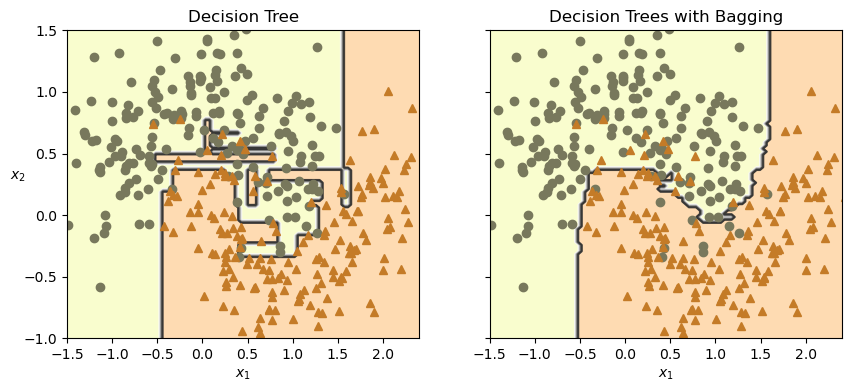

In [10]:
import matplotlib.pyplot as plt 
import numpy as np

def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
plt.show()

In the above figure, we can see the decision boundary of a single decision tree compared to that of a bagging ensemble of 500 trees. The ensemble's predictions will likely generalise much better than the single decision tree's preidctions: the ensemble has a comparable bias but a smaller variance. 

Bagging introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting: but the extra diversity also means that the predictors end up being less correalted, so the ensemble's variance is reduced.

Overall, bagging often results in better models.

<h3>7.3.1 Out-of-Bag Evaluation</h3>

With bagging, some training instances may be sampled several times for any given predictor, while others may not be sampled at all. By default a BaggingClassifier samples $m$ training instances with replacement, where $m$ is the size of the training set. With this process, only about 64% of the training instances are sampled on average for each predictor. The remaining 37% are called <em>out-of-bag</em> (OOB) instances.

A bagging ensemble acan be evaluated using OOB instnaces, without the need for a separate validation set. In Scikit-Learn, you set oob_score=True when creating a BaggingClassifier to request an automatic OOB evaluation after training.

In [11]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators = 500,
                            oob_score = True, n_jobs = -1, random_state = 42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

According to this OOB evaulating, this BaggingClassifier is likely to achieve about 89.6% accuracy on the test set. Let's verify this:

In [12]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.92

The OOB evaulation was a bit too pessimistic, just over 2% too low.

<h3>7.3.2 Random Patches and Random Subspaces</h3>

The BaggingClassifier class supports sampling the features as well. This technique, whereby each predictor is trained on a random subset of the input features, is particularly useful when you are dealing with high-dimension inputs (such as images), as it can considerably speed up training. Sampling both instances and features is called the <em>random patches method</em>. Keeping all training instances but sampling features is called the <em>random subspace method</em>.

<h2>7.4 Random Forest</h2>

A <em>Random Forest</em> is an ensemble of Decision Trees, generally trained via the bagging method, typically with max_samples set to the size of the training set. 

In [13]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16,
                                 n_jobs = -1, random_state = 42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

The random forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features.

<h3>7.4.1 Feature Importance</h3>

Random Forests make it easy to measure the relative importance of each feature. Scikit-Learn measures each feature's importance by looking at how much the tree nodes that use that feature reduce impurity on average, across all trees in the forest. More precisely, it is a weighted average, where each node's weight is equal to the number of training samples that are associated with it.

Scikit-Learn computes this score automatically for each feature after training, then it scales the results so that the sum of all importances is equal to 1. 

In [14]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


Similarly, if you train a random forest classifier on the MNIST dataset and plot each pixel's importance, you get the following:

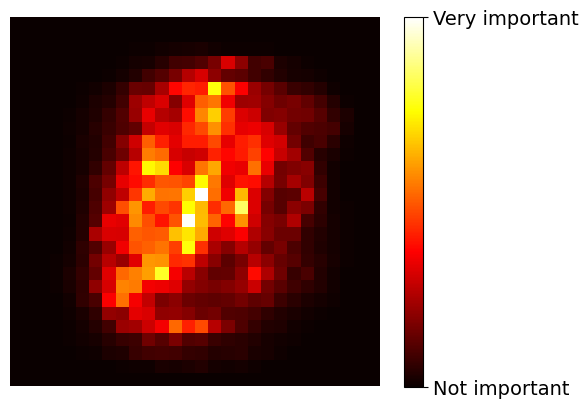

In [15]:
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False,
                                parser='auto')

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off")
plt.show()

<h2>7.5 Boosting</h2>

<em>Boosting</em> (originally called <em>hypothesis boosting</em>) refers to any ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. 

There are many boosting methods available, but the most popular are AdaBoost (short for Adaptive Boosting) and Gradient Boosting. 

<h3>7.5.1 Adadboost</h3>

One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfit. This results in a new predicvtor focusing more and more on the hard cases. This is the technique used by AdaBoost.

For example, when training an AdaBoost classifier, the algorithm first trains a base classifier (such as a decision tree) and uses it to make predictions on the training set. The algorithm then increases the relative weight of misclassified training instances. Then it trains a second classifier, using the updated weights, and again makes predictions on the training set, updates the instance weights, and so on. 

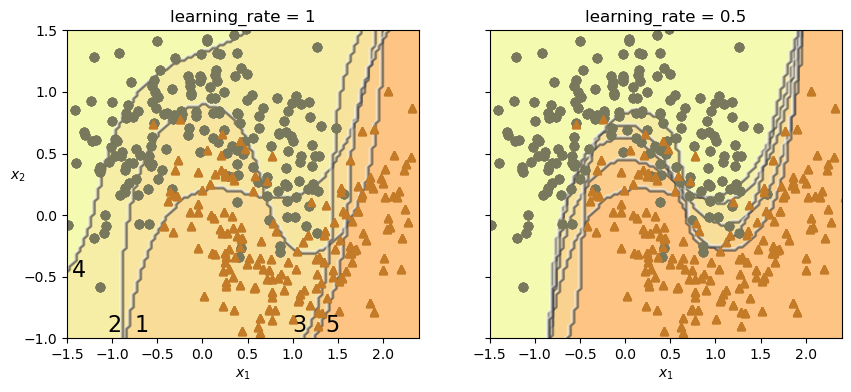

In [16]:
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        error_weights = sample_weights[y_pred != y_train].sum()
        r = error_weights / sample_weights.sum()  # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r)  # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # equation 7-3
        sample_weights /= sample_weights.sum()  # normalization step

        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.4)
        plt.title(f"learning_rate = {learning_rate}")
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36,  -0.95, "5", fontsize=16)
    else:
        plt.ylabel("")

plt.show()

The above figure shows the decision boundaries of five consecutive predictors on the moons dataset (in this example, each predictor is a highly regularised SVM classifier with an RBF kernel).

The first classifier gets many instances wrong, so their weights get boostsed. The second classifier does a better jon on these instances, and son. 

The plot on the right represents the same sequence of predictors, except the learning rate is halved (i.e. the misclassified instances are boosted much less at every iteration). This sequential learning technique has some similarities with Gradient Descent, except that instead of tweaking a single predictor's parameters to minimise a cost function, AdaBoost adds predictors to the ensemble, gradually making it better. 

The following code trains an AdaBoost classifier based on 30 decision stumps using Scikit-Learn's AdaBoostClassifier class. A decision stump is a decision tree with max_depth=1.

In [17]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth = 1), n_estimators = 30,
    learning_rate = 0.5, random_state = 42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

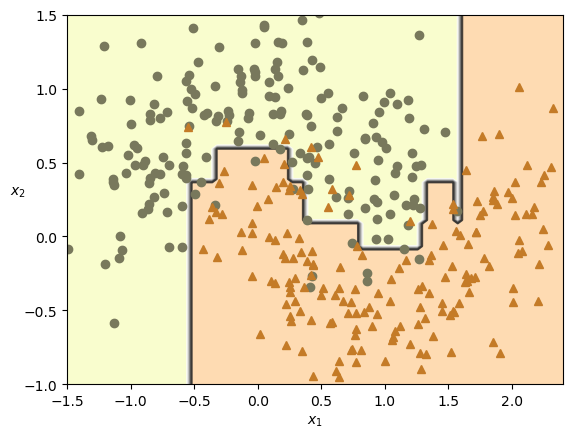

In [18]:
plot_decision_boundary(ada_clf, X_train, y_train)